In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/train.csv')

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_data.shape

(7613, 5)

In [7]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Removing special characters, uppercase letters and lemmatizing"""
    
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

In [10]:
train_data['text'] = train_data.text.apply(lambda x: clean_text(str(x)))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deed be the reason of this earthquake may ...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all resident ask to shelter in place be be not...,1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1
4,7,NaN,NaN,just get send this photo from ruby alaska a sm...,1


In [11]:
X = train_data['text']
y = train_data['target']

In [12]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
vocab_size = 1000
embedding_dim = 16
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_x)

word_index = tokenizer.word_index

training_sequence = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences(training_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequence = tokenizer.texts_to_sequences(test_x)
testing_padded = pad_sequences(testing_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(train_y)

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_y)

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [76]:
history = model.fit(training_padded, train_y, epochs=20, validation_data=(testing_padded, test_y), verbose=2)

Epoch 1/20
191/191 - 14s - loss: 0.5598 - binary_accuracy: 0.7044 - val_loss: 0.4585 - val_binary_accuracy: 0.7899
Epoch 2/20
191/191 - 7s - loss: 0.4421 - binary_accuracy: 0.8092 - val_loss: 0.4545 - val_binary_accuracy: 0.7984
Epoch 3/20
191/191 - 7s - loss: 0.4033 - binary_accuracy: 0.8263 - val_loss: 0.4605 - val_binary_accuracy: 0.7912
Epoch 4/20
191/191 - 7s - loss: 0.3824 - binary_accuracy: 0.8351 - val_loss: 0.4605 - val_binary_accuracy: 0.7892
Epoch 5/20
191/191 - 7s - loss: 0.3684 - binary_accuracy: 0.8452 - val_loss: 0.4884 - val_binary_accuracy: 0.7807
Epoch 6/20
191/191 - 7s - loss: 0.3585 - binary_accuracy: 0.8521 - val_loss: 0.5053 - val_binary_accuracy: 0.7800
Epoch 7/20
191/191 - 7s - loss: 0.3475 - binary_accuracy: 0.8594 - val_loss: 0.5020 - val_binary_accuracy: 0.7807
Epoch 8/20
191/191 - 7s - loss: 0.3354 - binary_accuracy: 0.8698 - val_loss: 0.5460 - val_binary_accuracy: 0.7768
Epoch 9/20
191/191 - 7s - loss: 0.3294 - binary_accuracy: 0.8708 - val_loss: 0.5070 - v

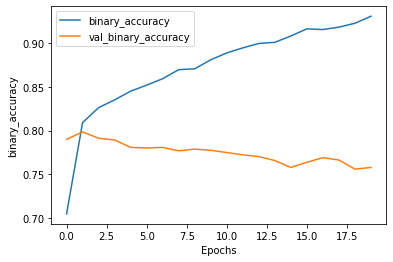

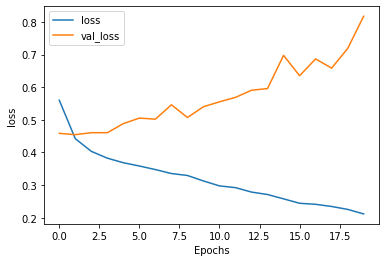

In [77]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")

In [78]:
model.evaluate(testing_padded, test_y, batch_size=128)

12/12 [==============================] - 0s 25ms/step - loss: 0.8172 - binary_accuracy: 0.7577


[0.8172408938407898, 0.7577150464057922]

In [79]:
test_data['text'] = test_data.text.apply(lambda x: clean_text(str(x)))

tokenizer.fit_on_texts(test_data.text)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(test_data.text)

test_text = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)

In [80]:
test_pred = model.predict(test_text)

In [54]:
test_pred = list(map(lambda x: 0 if x<0.5 else 1, test_pred))

In [81]:
submission = pd.DataFrame()
submission['Id'] = test_data.id
submission['target'] = test_pred

In [82]:
submission.target.nunique()

6801

In [83]:
submission.head()

,Id,target
0,1,0.054472
1,4,0.052299
2,5,0.060116
3,6,0.053155
4,7,0.073155


In [84]:
submission.target.max()

0.10422724485397339

In [23]:
submission.to_csv('submission1.csv', index=False)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
